# Assignment 4 - SMAI - CNN and AutoEncoders

In [13]:
import os
import sys

# enter the Foldername here:
FOLDERNAME = "/home/richard/play/IIITH/sem5/smai/assignments/assignment-3-fine-man"

if FOLDERNAME is None or not os.path.exists(FOLDERNAME):
    FOLDERNAME = os.getcwd()

PATHNAME = f"{FOLDERNAME}"
sys.path.append(f"{FOLDERNAME}")

# DATA_FOLDER = os.path.join(FOLDERNAME, "SMAI-Dataset-release/IIIT-CFW")
DATA_FOLDER = os.path.join(FOLDERNAME, "datasets")
YAML_FOLDER = os.path.join(FOLDERNAME, "yaml-files/task-4.3")
print(DATA_FOLDER)
print(YAML_FOLDER)

/home/vanshg/play/IIIITH/sem5/smai/assignments/assignment-3-fine-man/datasets
/home/vanshg/play/IIIITH/sem5/smai/assignments/assignment-3-fine-man/yaml-files/task-4.3


In [14]:
# some magic so that the notebook will reload external python modules;
# see https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import numpy as np
import pandas as pd
import scipy
import scipy.io
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
import wandb
import yaml

from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from torch.utils.data import random_split

import torchvision
from torchvision import transforms

In [18]:
from src_torch import *
from src_torch.utils import train, evaluate
from src_torch.classifiers import *

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## (4.1) - Data Visualization and Preprocessing

### (4.1.0) - Data Loading

In [20]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# loading the MNIST data
mnist_train = torchvision.datasets.MNIST(
    root=DATA_FOLDER, train=True,
    transform=transform, download=True
)

mnist_test = torchvision.datasets.MNIST(
    root=DATA_FOLDER, train=False,
    transform=transform, download=True
)

print(f"Length of Train data: {len(mnist_train)}")
print(f"Length of Test data: {len(mnist_test)}")

Length of Train data: 60000
Length of Test data: 10000


### (4.1.1) - Showing distribution of classes

In [9]:
labels = []
for data, label in mnist_train:
    labels.append(label)

labels = np.array(labels)

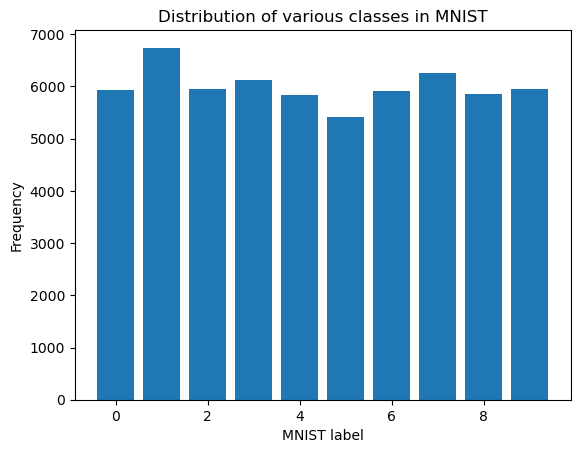

In [10]:
fig, ax = plt.subplots(1, 1)

unique_labels, label_freq = np.unique(labels, return_counts=True)

ax.bar(unique_labels, label_freq)
ax.set_title("Distribution of various classes in MNIST")
ax.set_xlabel("MNIST label")
ax.set_ylabel("Frequency")

plt.show()

### (4.1.2) Visualizing samples from MNIST dataset

In [293]:
features = mnist_train.data.view(-1, 28, 28)
labels = mnist_train.targets
print(features.shape)
print(labels.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


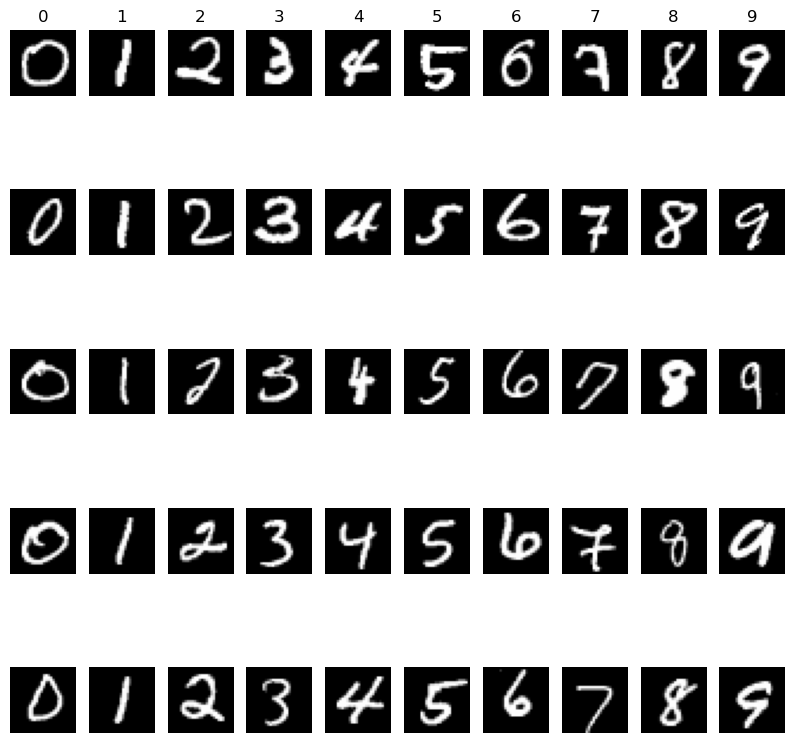

In [294]:
examples_per_class = 5
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.figure(figsize=(10, 10))
for cls_idx, cls_name in enumerate(classes):
    idxs = np.where(labels == cls_idx)[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls_idx + 1)
        plt.imshow(features[idx], cmap='gray')
        plt.axis("off")
        if i == 0:
            plt.title(f"{cls_name}")

plt.show()

### (4.1.4) Splitting data into train/val splits

In [21]:
val_ratio = 0.3
val_size = int(val_ratio * len(mnist_train))
train_size = len(mnist_train) - val_size

train_dataset, val_dataset = random_split(mnist_train, [train_size, val_size])

print(f"Length of Training Data: {len(train_dataset)}")
print(f"Length of Validation Data: {len(val_dataset)}")
print(f"Length of Testing Data: {len(mnist_test)}")

Length of Training Data: 42000
Length of Validation Data: 18000
Length of Testing Data: 10000


## (4.2) Model Building

### (4.2.3) Baseline CNN model

In [37]:
untrained_model = SimpleCNN()
print(untrained_model)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


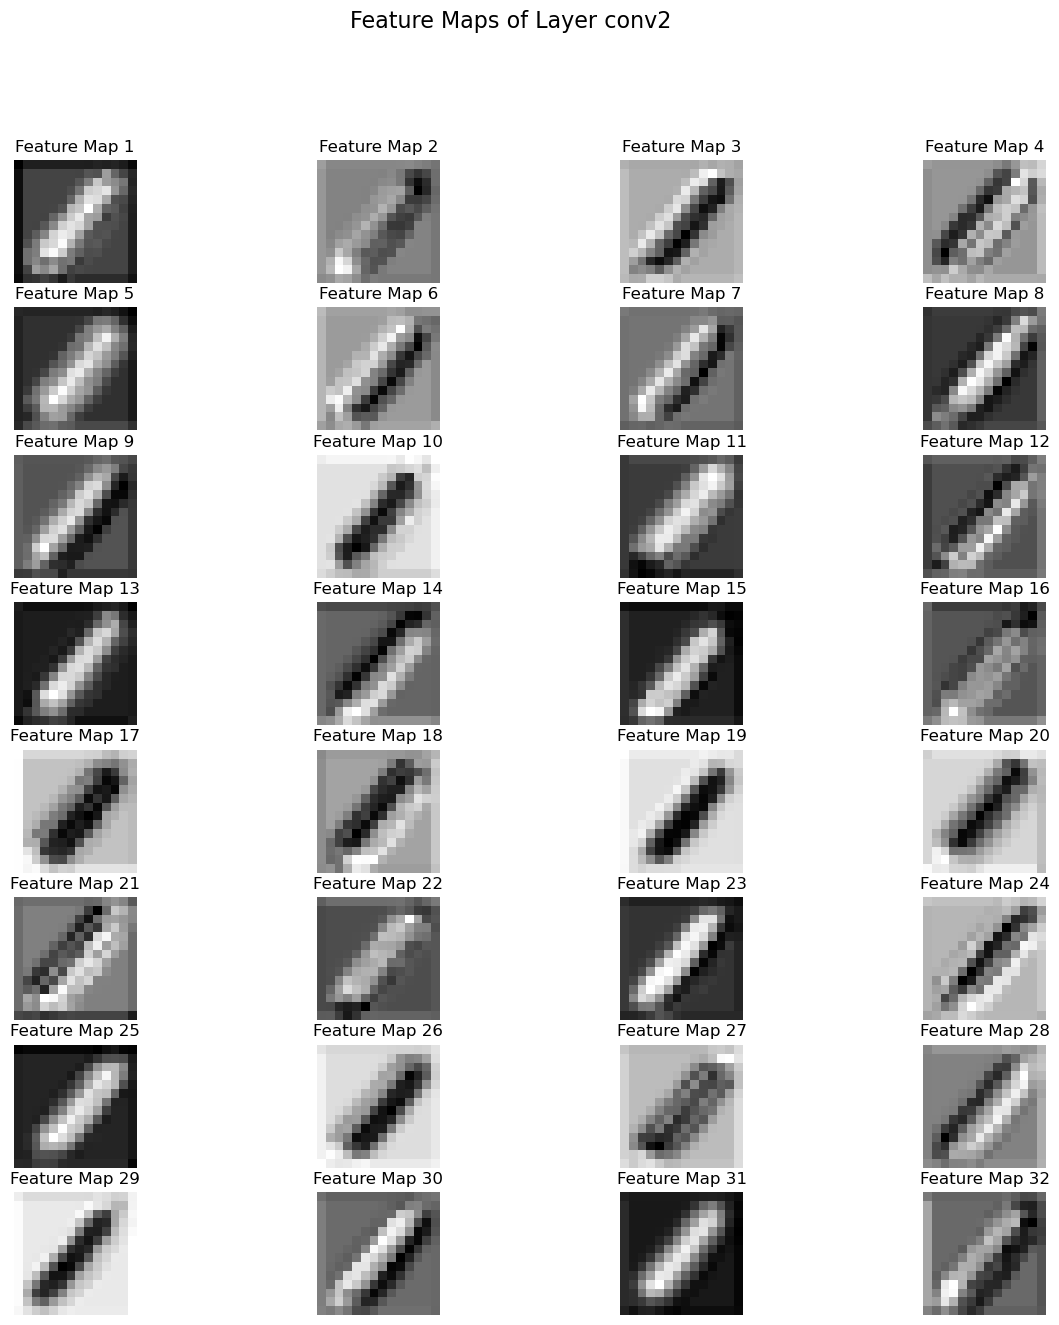

In [38]:
# Feature Maps before training
image, label = train_dataset[0]

visualize_feature_maps(untrained_model, image, 'conv2')

In [39]:
# Setup model, criterion and optimizer
model = SimpleCNN(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, criterion, optimizer, train_dataset, val_dataset, print_every=200, device='cuda')


Model is on device: cuda

Number of Iterations Per Epoch: 420


Iteration: 200/4200 | loss = 0.2975
Iteration: 400/4200 | loss = 0.0986
Epoch: 1 | Train Accuracy: 96.164 | Val Accuracy: 96.094|  Train loss: 0.1314 | Val loss: 0.1378

Iteration: 600/4200 | loss = 0.1156
Iteration: 800/4200 | loss = 0.0697
Epoch: 2 | Train Accuracy: 97.683 | Val Accuracy: 97.356|  Train loss: 0.0780 | Val loss: 0.0864

Iteration: 1000/4200 | loss = 0.0629
Iteration: 1200/4200 | loss = 0.1437
Epoch: 3 | Train Accuracy: 98.205 | Val Accuracy: 97.878|  Train loss: 0.0600 | Val loss: 0.0714

Iteration: 1400/4200 | loss = 0.0887
Iteration: 1600/4200 | loss = 0.0208
Epoch: 4 | Train Accuracy: 98.507 | Val Accuracy: 98.106|  Train loss: 0.0506 | Val loss: 0.0635

Iteration: 1800/4200 | loss = 0.0193
Iteration: 2000/4200 | loss = 0.0432
Epoch: 5 | Train Accuracy: 98.714 | Val Accuracy: 98.306|  Train loss: 0.0431 | Val loss: 0.0568

Iteration: 2200/4200 | loss = 0.1288
Iteration: 2400/4200 | loss = 0.1209
Epoch: 6 | Train Accuracy: 98.867 | Val Accuracy: 98.339|  Train loss:

([0.9616428571428571,
  0.9768333333333333,
  0.9820476190476191,
  0.9850714285714286,
  0.9871428571428571,
  0.9886666666666667,
  0.9898571428571429,
  0.9905952380952381,
  0.9921904761904762,
  0.9916904761904762],
 [0.9609444444444445,
  0.9735555555555555,
  0.9787777777777777,
  0.9810555555555556,
  0.9830555555555556,
  0.9833888888888889,
  0.9845,
  0.9844444444444445,
  0.9862222222222222,
  0.9855],
 [0.13137960527979192,
  0.07801366592979148,
  0.059958926935325424,
  0.05064086831795673,
  0.04305227178126751,
  0.038503184573103984,
  0.032960006772607034,
  0.03144459117902443,
  0.0271355744201823,
  0.02707871170076985],
 [0.1377504868225919,
  0.08643203725417455,
  0.07144210336005521,
  0.06353465451910678,
  0.056826458113371496,
  0.054922933106879804,
  0.05040596702731111,
  0.05100196294564133,
  0.04604200540343299,
  0.048623379301797186])

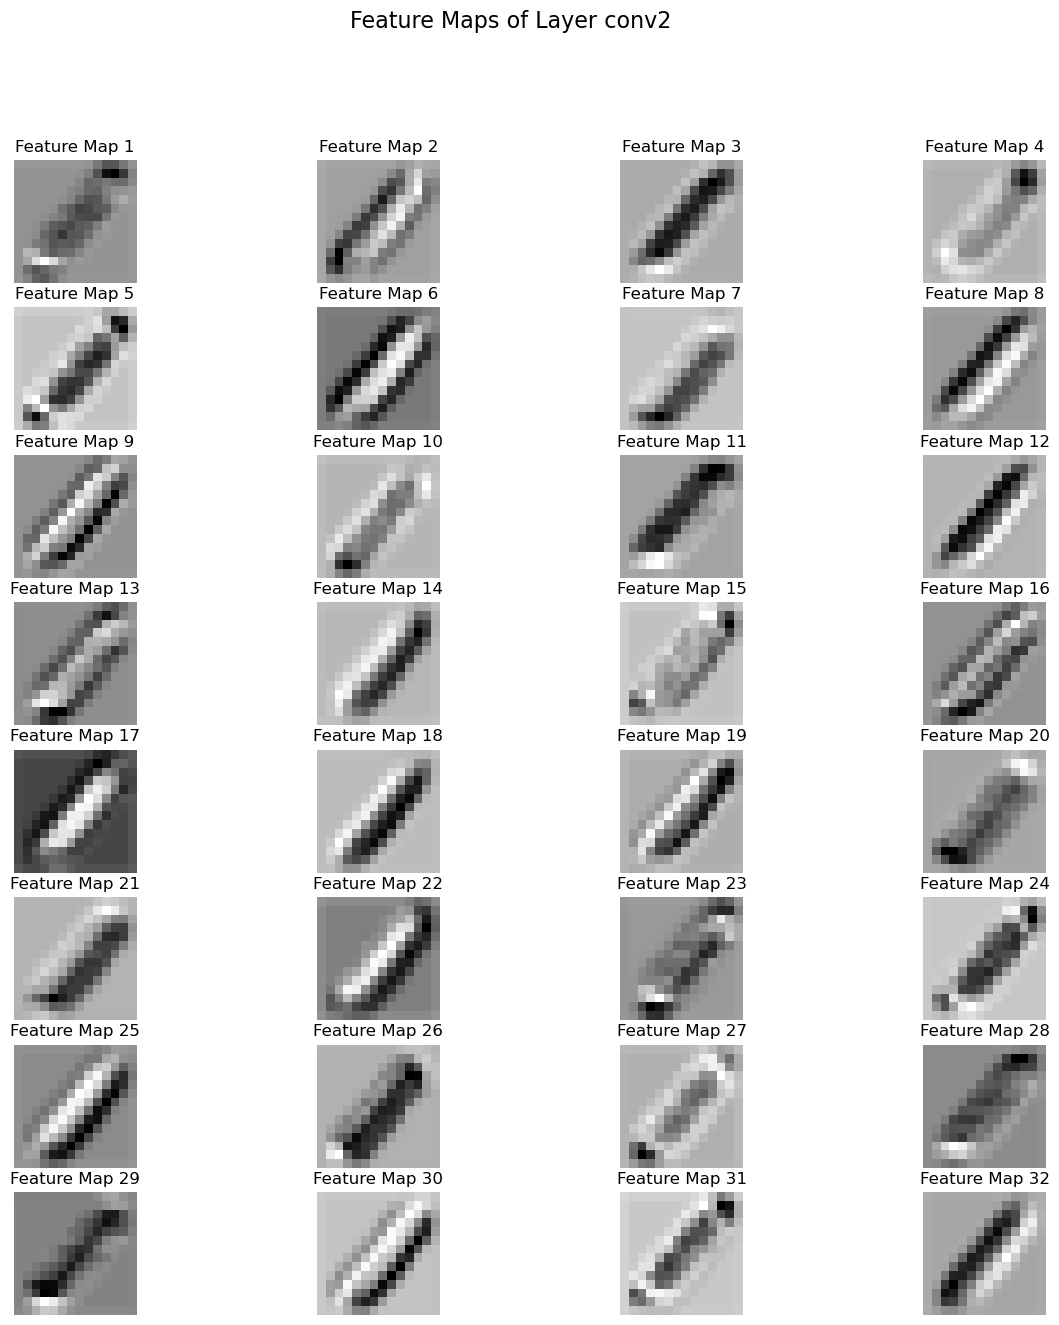

In [41]:
# Feature Maps before training
image, label = train_dataset[0]

visualize_feature_maps(model, image, 'conv2')

## (4.3) Hyper-parameter Tuning and Evaluation

In [13]:
def get_model(config):
    num_classes = config.pop("num_classes", 10)
    num_channels = config.pop("num_channels", 16)
    dropout = config.pop("dropout", 0.1)
    num_conv_layers = config.pop("num_conv_layers", 2)
    kernel_size = config.pop("kernel_size", 3)
    stride = config.pop("stride", 1)
    
    model = SimpleCNN(
        num_classes, kernel_size, stride, num_channels, dropout
    )
    return model

def get_criterion(crit_name):
    if crit_name == "CE":
        return nn.CrossEntropyLoss()
    else:
        return nn.CrossEntropyLoss()

def get_optimizer(config, model):
    lr = config["learning_rate"]
    optimizer = optim.Adam(model.parameters(), lr=lr)
    return optimizer

def trigger_training(config, train_dataset, val_dataset):
    np.random.seed(42)
    # getting the model, criterion and optimizer
    model = get_model(config["model"])
    print(model, flush=True)
    criterion = get_criterion(config["criterion"])
    optimizer = get_optimizer(config["optimizer"], model)

    # training config
    train_config = config["training"]
    device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
    
    train(
        model, criterion, optimizer, train_dataset, val_dataset, device=device, **train_config)
    
    return model

In [15]:
def make_wandb_run_name(config):
    model_config = config["model"]
    optim_config = config["optimizer"]
    train_config = config["training"]

    channels = model_config["num_channels"]
    kernel = model_config["kernel_size"]
    stride = model_config["stride"]
    dropout = model_config["dropout"]

    lr = optim_config["learning_rate"]
    batch = train_config["batch_size"]

    run_name = f"C{channels}-k{kernel}-s{stride}-dropout{dropout}-lr{lr}-batch{batch}"
    return run_name

In [16]:
def sweep_agent_manager():
    global train_dataset, val_dataset
    run = wandb.init()
    config = re_nest_config(dict(wandb.config))
    # setting the wandb run name for the current config
    run_name = make_wandb_run_name(config)
    print(f"Run Name: {run_name}")
    run.name = run_name
    # start the training
    trigger_training(config, train_dataset, val_dataset)

In [11]:
# testing out sweep using a single config
config = {
    "method": "grid",
    "name": "sgd-grid-search",
    "parameters": {
        "criterion": "CE",
        "model": {
            "num_conv_layers": 2,
            "num_channels": 16,
            "kernel_size": 5,
            "stride": 1,
            "dropout": 0.1,
            "num_classes": 10,
        },
        "optimizer": {
            "learning_rate": 1e-2,
        },
        "training": {
            "batch_size": 100,
            "epochs": 10,
            "print_every": 100,
            "log_wandb": True,
            "verbose": True
        }
    }
}

In [ ]:
wandb.init(
    project="smai-assignment3-task4",
    config=config
)

wandb.run.name = "testing"
trigger_training(config["parameters"], train_dataset, val_dataset)
wandb.finish()

In [12]:
model = get_model(config["parameters"]["model"])
optimizer = get_optimizer(config["parameters"]["optimizer"], model)
criterion = get_criterion(config["parameters"])

print(model)
print(optimizer)
print(criterion)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
CrossEntropyLoss()


In [17]:
f = open(os.path.join(YAML_FOLDER, "two-conv-grid.yaml"), "r")

sweep_configuration = yaml.safe_load(f)
print(sweep_configuration)

{'method': 'grid', 'project': 'smai-assignment3-task4', 'name': 'two-conv-layers-grid-search', 'parameters': {'criterion': {'value': 'CE'}, 'model.conv_layers': {'value': 2}, 'model.num_channels': {'values': [32, 64, 128]}, 'model.kernel_size': {'values': [1, 3, 5]}, 'model.stride': {'values': [1, 3, 5]}, 'model.dropout': {'values': [0, 0.1, 0.25]}, 'model.num_classes': {'value': 10}, 'optimizer.learning_rate': {'values': [0.0005, 0.001, 0.01]}, 'training.batch_size': {'values': [64, 128]}, 'training.epochs': {'value': 20}, 'training.log_wandb': {'value': True}, 'training.verbose': {'value': True}, 'training.print_every': {'value': 100}}}


In [18]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project="smai-assignment3-task4")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /home/vanshg/.netrc


Create sweep with ID: nrul5ozz
Sweep URL: https://wandb.ai/vanshg/smai-assignment3-task4/sweeps/nrul5ozz


In [ ]:
wandb.agent(sweep_id=sweep_id, function=sweep_agent_manager)

## (4.4) Model Evaluation and Analysis

### (4.4.1) Evaluating best model on Test Dataset

In [81]:
best_model = model
test_acc, test_loss = evaluate(best_model, mnist_test)

print(f"\nTest Accuracy: {test_acc*100:.4f} | Test Loss: {test_loss:.4f}")


Test Accuracy: 98.7600 | Test Loss: 0.0373


In [82]:
y_pred, y_true = predict(best_model, mnist_test, device='cuda', return_true_labels=True)
y_pred = y_pred.numpy()
y_true = y_true.numpy()

# print(f"\nShape of Predictions: {y_preds.shape}") # (10000,)
# print(f"Shape of true labels: {true_labels.shape}") # (10000,)

print(f"\nClassification Report")
print(classification_report(y_true, y_pred))

Model is on device: cuda
Total number of iterations: 100

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.99      1032
           3       1.00      0.98      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.99      0.98      0.99       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



### (4.4.2) - Confusion Matrix for Test Dataset

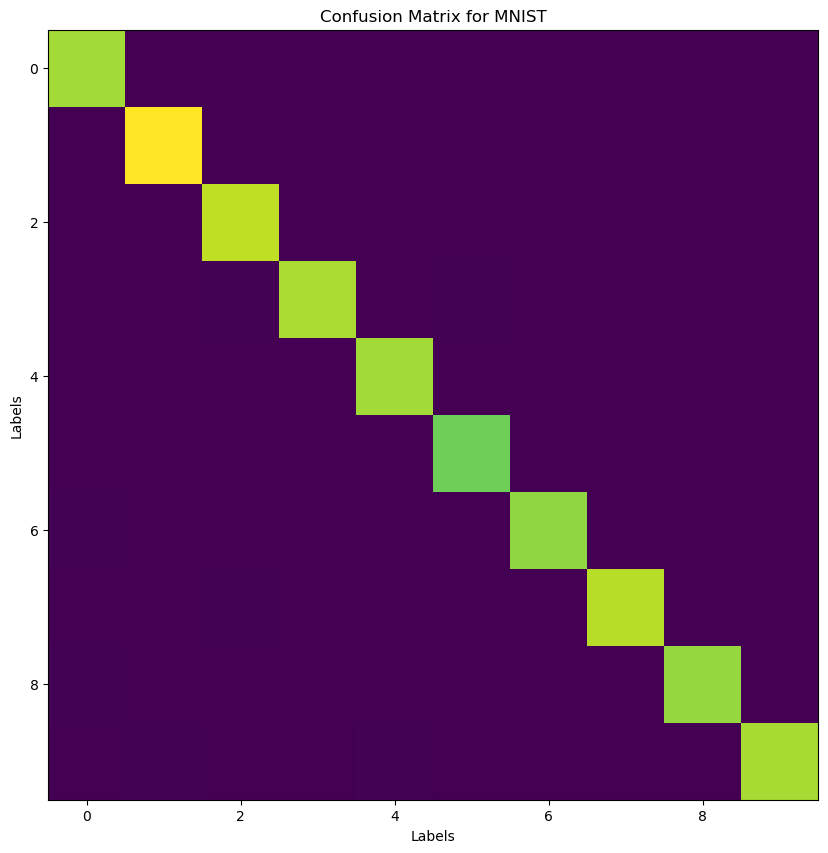

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.set_title("Confusion Matrix for MNIST")
ax.set_xlabel('Labels')
ax.set_ylabel('Labels')
ax.imshow(confusion_matrix(y_true, y_pred))

plt.show()

### (4.4.3) - Visualizing Incorrect Predictions

In [85]:
incorrect_idx = np.nonzero(y_pred != y_true)[0]

print(f"Number of incorrect examples: {incorrect_idx.shape}")

num_display = 16
indices = np.random.choice(incorrect_idx, num_display, replace=False)

# Number of rows to display
images_per_row = 4
num_rows = num_display // images_per_row
if num_display % images_per_row != 0:
    num_rows += 1

fig, axs = plt.subplots(num_rows, images_per_row, figsize=(12, 12))
axs = axs.flatten()

for i, idx in enumerate(indices):
    predicted = y_pred[idx]
    true_label = y_true[idx]
    axs[i].set_title(f"True Label: {true_label}\nPredicted: {predicted}")
    axs[i].axis('off')
    axs[i].imshow(mnist_test[idx][0].squeeze())

plt.show()

Number of incorrect examples: (124,)


ValueError: Number of rows must be a positive integer, not (4, 4)

<Figure size 1200x1200 with 0 Axes>

## (4.5) Train on Noisy Dataset

### (4.5.0) - Splitting Data into Train/Val sets

In [28]:
torch.manual_seed(0)
np.random.seed(0)
noisy_mnist = scipy.io.loadmat(os.path.join(DATA_FOLDER, "mnist-with-awgn.mat"))

X_train, X_test = noisy_mnist['train_x'], noisy_mnist['test_x']
y_train, y_test = noisy_mnist['train_y'], noisy_mnist['test_y']

# Converting them to Tensors
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 1, 28, 28) # (N, C, H, W)
# Scaling images to bring them to range [0, 1]
X_train = X_train/255.0
y_train = torch.tensor(y_train, dtype=torch.float32)
y_train = torch.argmax(y_train, dim=1)

X_test = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 1, 28, 28) # (N, C, H, W)
X_test = X_test/255.0
y_test = torch.tensor(y_test, dtype=torch.float32)
y_test = torch.argmax(y_test, dim=1)

print(f"Shape of Train Data = {X_train.shape}, {y_train.shape}, {X_train.dtype}")
print(f"Shape of Test Data: {X_test.shape}, {y_test.shape}, {X_test.dtype}")
print()

# Converting them to Pytorch Datasets
train_dataset_noisy = TensorDataset(X_train, y_train)
test_dataset_noisy = TensorDataset(X_test, y_test)

# Splitting into Train/Val splits
val_ratio = 0.3
val_size = int(val_ratio * len(X_train))
train_size = len(X_train) - val_size

train_dataset_noisy, val_dataset_noisy = random_split(train_dataset_noisy, [train_size, val_size])

print(f"Length of Training Dataset: {len(train_dataset)}")
print(f"Length of Validation Data: {len(val_dataset)}")
print(f"Length of Testing Data: {len(test_dataset_noisy)}")

Shape of Train Data = torch.Size([60000, 1, 28, 28]), torch.Size([60000]), torch.float32
Shape of Test Data: torch.Size([10000, 1, 28, 28]), torch.Size([10000]), torch.float32

Length of Training Dataset: 42000
Length of Validation Data: 18000
Length of Testing Data: 10000


In [36]:
torch.manual_seed(0)
np.random.seed(0)

model = SimpleCNN(dropout=0.25, num_channels=8, kernel_size=7)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

_ = train(model, criterion, optimizer, train_dataset_noisy, val_dataset_noisy, device='cuda', print_every=100)


Model is on device: cuda

Number of Iterations Per Epoch: 420


Iteration: 100/4200 | loss = 0.1696
Iteration: 200/4200 | loss = 0.2903
Iteration: 300/4200 | loss = 0.0857
Iteration: 400/4200 | loss = 0.0962
Epoch: 1 | Train Accuracy: 96.907 | Val Accuracy: 96.267|  Train loss: 0.1006 | Val loss: 0.1198

Iteration: 500/4200 | loss = 0.1127
Iteration: 600/4200 | loss = 0.2284
Iteration: 700/4200 | loss = 0.0755
Iteration: 800/4200 | loss = 0.0934
Epoch: 2 | Train Accuracy: 97.845 | Val Accuracy: 97.117|  Train loss: 0.0680 | Val loss: 0.0987

Iteration: 900/4200 | loss = 0.1127
Iteration: 1000/4200 | loss = 0.0379
Iteration: 1100/4200 | loss = 0.1113
Iteration: 1200/4200 | loss = 0.1085
Epoch: 3 | Train Accuracy: 97.779 | Val Accuracy: 96.906|  Train loss: 0.0717 | Val loss: 0.1017

Iteration: 1300/4200 | loss = 0.1388
Iteration: 1400/4200 | loss = 0.0614
Iteration: 1500/4200 | loss = 0.1128
Iteration: 1600/4200 | loss = 0.1347
Epoch: 4 | Train Accuracy: 97.543 | Val Accuracy: 96.567|  Train loss: 0.0762 | Val loss: 0.1152

Iteration: 1700/4200 | lo

In [31]:
test_acc, test_loss = evaluate(model, test_dataset_noisy, device='cuda')
print(f"Test Accuracy: {test_acc*100:.4f} | Test Loss: {test_loss:.4f}")

Test Accuracy: 96.7100 | Test Loss: 0.1068


In [34]:
preds, true_labels = predict(model, test_dataset_noisy, device='cuda', return_true_labels=True)
preds = preds.numpy()
true_labels = true_labels.numpy()

print(f"Shape of predictions: {preds.shape}")
print(f"Shape of True labels = {true_labels.shape}")

print("Classification Report:\n")
print(classification_report(true_labels, preds))

Model is on device: cuda
Total number of iterations: 100
Shape of predictions: (10000,)
Shape of True labels = (10000,)
Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.97      0.97      0.97      1032
           3       0.95      0.98      0.96      1010
           4       0.99      0.95      0.97       982
           5       0.97      0.95      0.96       892
           6       0.98      0.97      0.98       958
           7       0.98      0.95      0.97      1028
           8       0.96      0.95      0.95       974
           9       0.94      0.96      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



## (4.6) - AutoEncoder for Noisy MNIST

In [233]:
class SimpleAutoencoder(nn.Module):
    def __init__(
            self, 
            num_channels=8, 
            kernel_size=3, 
            stride=1
        ):
        super(SimpleAutoencoder, self).__init__()

        # Encoder
        in_dim = 28
        k = kernel_size
        s = stride
        pad = (in_dim * (s - 1) + k - s) // 2

        self.encoder = nn.Sequential(
            nn.Conv2d(1, num_channels, kernel_size=k, stride=s, padding=pad),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(num_channels, 2 * num_channels, kernel_size=k, stride=s, padding=pad),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Decoder
        in_channels = 2 * num_channels
        out_channels = num_channels

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(out_channels, 1, kernel_size=2, stride=2),
            nn.Sigmoid()  # Sigmoid activation for output image reconstruction
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [226]:
autoencoder_train_dataset = TensorDataset(X_train, X_train)
autoencoder_test_dataset = TensorDataset(X_test, X_test)

print(f"Length of train dataset: {len(autoencoder_train_dataset)}")
print(f"Length of test dataset: {len(autoencoder_test_dataset)}")

Length of train dataset: 60000
Length of test dataset: 10000


In [239]:
torch.manual_seed(0)
autoencoder_model = SimpleAutoencoder(num_channels=4, kernel_size=3, stride=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder_model.parameters(), lr=0.001)

train_config = {
    'device': 'cuda',
    'print_every': 200,
    "batch_size": 30,
    'calc_accuracy': False,
    'epochs': 5
}

_, _ = train(autoencoder_model, criterion, optimizer, autoencoder_train_dataset, autoencoder_test_dataset, **train_config)


Model is on device: cuda

Number of Iterations Per Epoch: 2000


Iteration: 200/10000 | loss = 0.0760
Iteration: 400/10000 | loss = 0.0628
Iteration: 600/10000 | loss = 0.0610
Iteration: 800/10000 | loss = 0.0561
Iteration: 1000/10000 | loss = 0.0570
Iteration: 1200/10000 | loss = 0.0558
Iteration: 1400/10000 | loss = 0.0542
Iteration: 1600/10000 | loss = 0.0510
Iteration: 1800/10000 | loss = 0.0494
Iteration: 2000/10000 | loss = 0.0480
Epoch: 1 |  Train loss: 0.0484 | Val loss: 0.0484

Iteration: 2200/10000 | loss = 0.0473
Iteration: 2400/10000 | loss = 0.0457
Iteration: 2600/10000 | loss = 0.0469
Iteration: 2800/10000 | loss = 0.0452
Iteration: 3000/10000 | loss = 0.0451
Iteration: 3200/10000 | loss = 0.0445
Iteration: 3400/10000 | loss = 0.0430
Iteration: 3600/10000 | loss = 0.0439
Iteration: 3800/10000 | loss = 0.0435
Iteration: 4000/10000 | loss = 0.0428
Epoch: 2 |  Train loss: 0.0433 | Val loss: 0.0432

Iteration: 4200/10000 | loss = 0.0425
Iteration: 4400/10000 | loss = 0.0434
Iteration: 4600/10000 | loss = 0.0428
Iteration: 4800/10000 | loss

<class 'numpy.ndarray'>


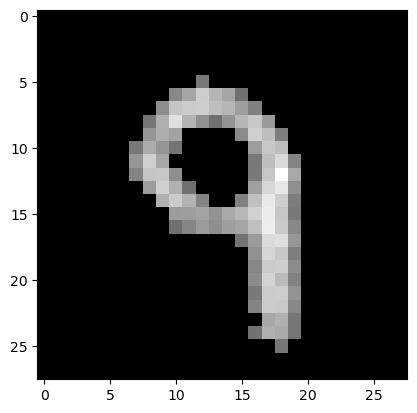

In [255]:
img_np, _ = train_dataset_noisy[0]
img_np = img_np.squeeze().numpy()

print(type(img_np))

min_image = cv2.GaussianBlur(img_np, (3, 3), 10) * 255.0
min_image[min_image < 100] = 0

plt.imshow(min_image, cmap='gray')

torch.Size([28, 28])


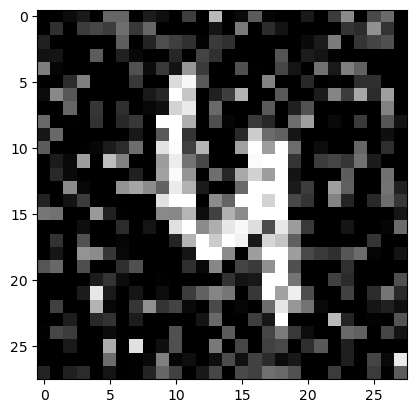

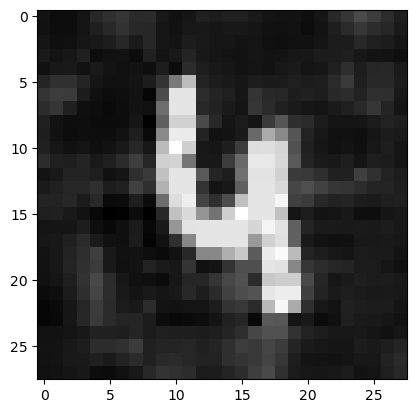

In [241]:
autoencoder_model.eval()
with torch.no_grad():
    i = 0
    img1, img2 = autoencoder_train_dataset[i]
    img1 = img1.unsqueeze(0).to(device)
    img2 = img2.squeeze().detach().cpu()

    out = autoencoder_model(img1).detach().squeeze().cpu()
    print(out.shape)

    plt.imshow(img2, cmap='gray')
    plt.show()

    plt.imshow(out, cmap='gray')
    plt.show()

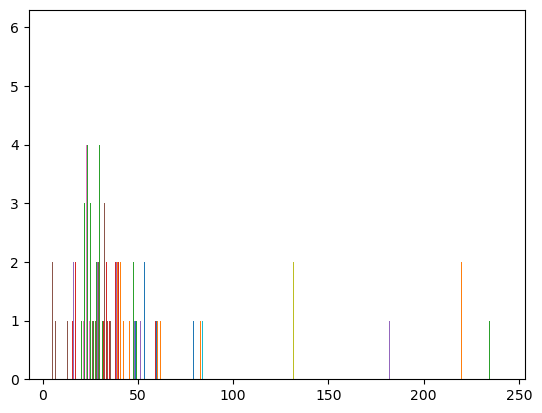

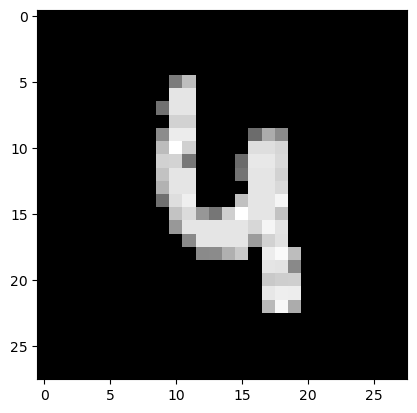

In [258]:
new_img = out * 255.0
plt.hist(new_img, bins=150)
plt.show()

new_img[new_img < 100] = 0
plt.imshow(new_img, cmap='gray')
plt.show()